In [396]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import BraveSearch

from langchain_core.tools import tool

import requests
import os

In [397]:
load_dotenv()

os.environ['LANGCHAIN_PROJECT']="langgraph tools demo"

In [398]:
# llm=ChatGroq(model='llama-3.1-8b-instant')
llm =ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [399]:
# tools: 

# 1 inbuilt tool
duck_search=DuckDuckGoSearchRun()

# 2 user defined tool
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}
    
# 3 api call tool
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=CBPKAGE0O4GQQVZ7"
    r = requests.get(url)
    return r.json()


In [400]:
# make tool list

tools=[get_stock_price, duck_search, calculator]

# make the llm tool-aware
llm_with_tools=llm.bind_tools(tools)

In [401]:
# state: 
class ChatState(TypedDict): 
    messages: Annotated[list[BaseMessage], add_messages]

In [402]:
#graph nodes: 
def chat_node(state: ChatState): 
    """LLM node that may answer or request a tool call"""
    messages=state['messages']
    response=llm_with_tools.invoke(messages)    
    return {'messages':[response]}

tool_node=ToolNode(tools) # executes tool calls

In [403]:
# graph structure
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [404]:
graph.add_edge(START, "chat_node")

# If the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")   

In [405]:
chatbot=graph.compile()


# START
#   ↓
# chat_node (LLM thinks)
#   ↓
# [tool needed?]
#   ├── Yes → tools → chat_node
#   └── No  → END

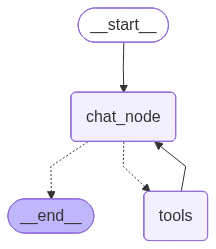

In [406]:
chatbot




In [407]:
response = chatbot.invoke({"messages": [HumanMessage(content="what is the today's trading news in india")]})
response['messages'][-1].content

"Here's a summary of today's trading news in India:\n\n*   **IPL 2024 Retention:** Hardik Pandya is expected to join Mumbai Indians.\n*   **Market Performance:** Indian domestic benchmarks continued their upward trend for the ninth consecutive session, despite a volatile trading environment.\n*   **Economic Trends:** There's a growing need for new income sources among Indian consumers due to business downsizing and rising employment.\n*   **Stock Market Trading:** Information is available on how to trade stocks in India today."

In [408]:
response['messages'][-1].content

"Here's a summary of today's trading news in India:\n\n*   **IPL 2024 Retention:** Hardik Pandya is expected to join Mumbai Indians.\n*   **Market Performance:** Indian domestic benchmarks continued their upward trend for the ninth consecutive session, despite a volatile trading environment.\n*   **Economic Trends:** There's a growing need for new income sources among Indian consumers due to business downsizing and rising employment.\n*   **Stock Market Trading:** Information is available on how to trade stocks in India today."

In [409]:
response

{'messages': [HumanMessage(content="what is the today's trading news in india", additional_kwargs={}, response_metadata={}, id='9641cb65-98f1-41ab-a332-436eae6679ec'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "today\'s trading news in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--d5c8bda8-4381-4028-8a2c-fd5c3ed484b7-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': "today's trading news in India"}, 'id': 'a945869d-126a-45b1-84b9-d5bc670edfb8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 78, 'total_tokens': 302, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 55}}),
  ToolMessage(content='IPL 2024 RETENTION: Check Indian Premier Leagues 2024 trading , released, reta